

# Q7: What are the most important features or well-log measurements contributing to lithology prediction?
    a. Use feature selection algorithms to identify the most important features for lithology prediction.
    b. Compare the accuracy loss to the cost reduction

**Purpose of the question**: can we reduce the readings acquired from the well to reduce the cost

In [1]:
import lasio
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from utils import *
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Data/labeled_logs.csv")
rename_columns(df)
resistivity_to_log10(df)


In [3]:
df = df.drop(
    [
        My_Columns.FORMATION,
        My_Columns.GROUP,
        My_Columns.WELL,
        My_Columns.X_LOC,
        My_Columns.Y_LOC,
        My_Columns.Z_LOC,
        My_Columns.WELL,
        My_Columns.CONFIDENCE,
        My_Columns.AVERAGE_RATE_OF_PENETRATION,
        My_Columns.WEIGHT_OF_DRILLING_MUD,
        My_Columns.FLUSHED_ZONE_RESISTIVITY,
        My_Columns.DIFFERENTIAL_CALIPER,
        My_Columns.SPECTRA_GAMMA_RAY,
        My_Columns.SHEAR_WAVE_SONIC,
        My_Columns.MICRO_RESISTIVITY,
    ],
    axis=1,
)
df.isnull().sum()
df = df.dropna()

In [4]:
df.columns, len(df.columns)


(Index(['Measured Depth', 'Caliper', 'Shallow Resistivity',
        'Medium Deep Resistivity', 'Deep Resistivity', 'Bulk Density',
        'Gamma Ray', 'Neutron Porosity', 'Photo Electric Factor',
        'Compressional waves sonic', 'Self Potential', 'Borehole Size',
        'Rate of Penetration', 'Density Correction', 'LITHOLOGY'],
       dtype='object'),
 15)

In [5]:
rename_lithology(df)
lithology_to_class(df)
df_original = df.copy()


In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)


train_X = train.drop([My_Columns.LITHOLOGY], axis=1)
train_Y = train[My_Columns.LITHOLOGY]

test_X = test.drop([My_Columns.LITHOLOGY], axis=1)
test_Y = test[My_Columns.LITHOLOGY]


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_Y)


print("Accuracy: ", accuracy_score(test_Y, rf.predict(test_X)))


Accuracy:  0.9639106358602253


<Axes: >

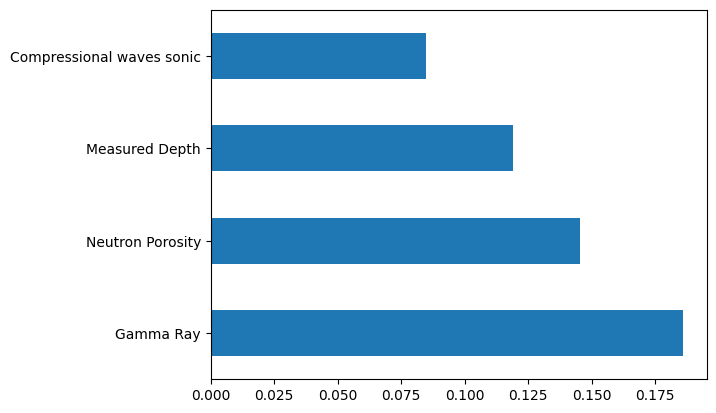

In [8]:
(
    pd.Series(rf.feature_importances_, index=train_X.columns)
    .nlargest(4)
    .plot(kind="barh")
)


According to petrophysics Neutron Porosity and Gamma rays are the best lithological indicators, however Neutron porosity is very expensive to measure, can we do without it?


In [9]:
train_X = train_X.drop([My_Columns.NEUTRON_POROSITY], axis=1)
test_X = test_X.drop([My_Columns.NEUTRON_POROSITY], axis=1)


In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_Y)

print("Accuracy: ", accuracy_score(test_Y, rf.predict(test_X)))


Accuracy:  0.9629558907771625


<Axes: >

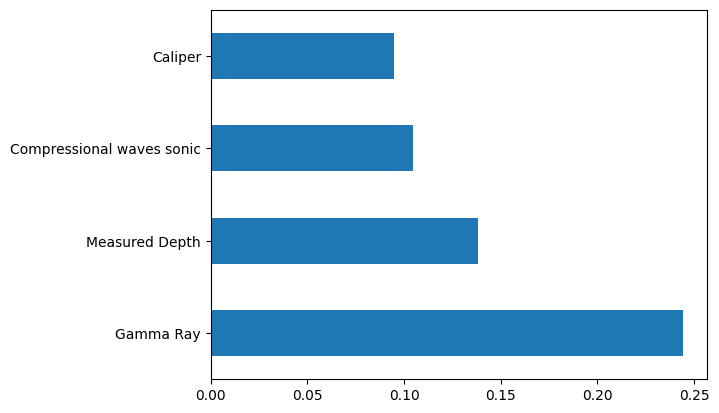

In [11]:
(
    pd.Series(rf.feature_importances_, index=train_X.columns)
    .nlargest(4)
    .plot(kind="barh")
)


Very good accuracy but Caliper isn't a feature of the Earth's crust, it is human made, and so is Measured depth. How well can we do without them?


In [12]:
train_X = train_X.drop(
    [
        My_Columns.DEPTH,
        My_Columns.CALIPER,
        My_Columns.BOREHOLE_SIZE,
        My_Columns.RATE_OF_PENETRATION,
    ],
    axis=1,
)
test_X = test_X.drop(
    [
        My_Columns.DEPTH,
        My_Columns.CALIPER,
        My_Columns.BOREHOLE_SIZE,
        My_Columns.RATE_OF_PENETRATION,
    ],
    axis=1,
)


In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_Y)

print("Accuracy: ", accuracy_score(test_Y, rf.predict(test_X)))


Accuracy:  0.9520717968302463


<Axes: >

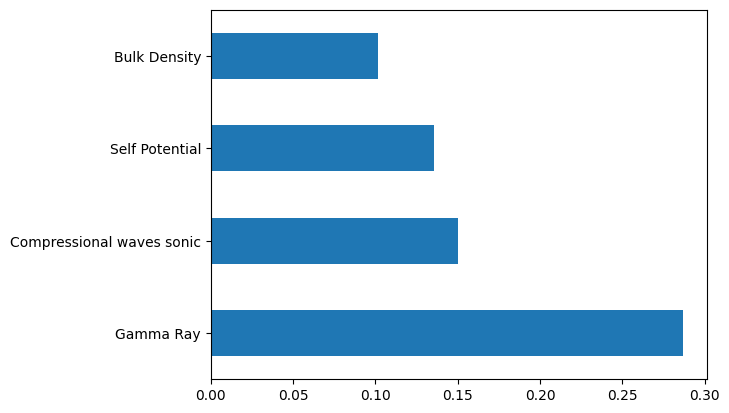

In [14]:
(
    pd.Series(rf.feature_importances_, index=train_X.columns)
    .nlargest(4)
    .plot(kind="barh")
)


There is a drop in the accuracy, however the selected features are more meaningful now (and less expensive)


In [15]:
train_X.columns

Index(['Shallow Resistivity', 'Medium Deep Resistivity', 'Deep Resistivity',
       'Bulk Density', 'Gamma Ray', 'Photo Electric Factor',
       'Compressional waves sonic', 'Self Potential', 'Density Correction'],
      dtype='object')

In [16]:
reduced_df = df_original.drop(
    [
        My_Columns.DEPTH,
        My_Columns.CALIPER,
        My_Columns.BOREHOLE_SIZE,
        My_Columns.RATE_OF_PENETRATION,
        My_Columns.NEUTRON_POROSITY,
    ],
    axis=1,
)

train, test = train_test_split(reduced_df, test_size=0.2, random_state=42)
train_X = train.drop([My_Columns.LITHOLOGY], axis=1)
train_Y = train[My_Columns.LITHOLOGY]
test_X = test.drop([My_Columns.LITHOLOGY], axis=1)
test_Y = test[My_Columns.LITHOLOGY]

In [17]:
if not os.path.isfile("model_feature_selection.csv"):
    current_columns = set()
    current_accuracy = 0
    with open("model_feature_selection.csv", "w") as f:
        f.write("Columns;Accuracy\n")
        while len(current_columns) < len(train_X.columns):
            MAX_ACCURACY = 0
            BEST_FEATURES = []
            for i in range(len(train_X.columns)):
                iter_columns = current_columns.copy()
                iter_columns.add(train_X.columns[i])
                if len(iter_columns) == len(current_columns):
                    continue
                train_X_temp = train_X[list(iter_columns)]
                test_X_temp = test_X[list(iter_columns)]
                clf = RandomForestClassifier(n_estimators=100, random_state=42)
                clf.fit(train_X_temp, train_Y)
                pred_Y = clf.predict(test_X_temp)
                print(
                    "Columns: ",
                    list(iter_columns),
                    " Accuracy: ",
                    accuracy_score(test_Y, pred_Y),
                )
                f.write(
                    str(list(iter_columns))
                    + ";"
                    + str(accuracy_score(test_Y, pred_Y))
                    + "\n"
                )
                if accuracy_score(test_Y, pred_Y) > MAX_ACCURACY:
                    MAX_ACCURACY = accuracy_score(test_Y, pred_Y)
                    BEST_FEATURES = iter_columns.copy()
            if np.round(100 * MAX_ACCURACY) <= np.round(100 * current_accuracy):
                print("Accuracy did not improve")
                print(
                    "current_accuracy: ",
                    current_accuracy,
                    " MAX_ACCURACY: ",
                    MAX_ACCURACY,
                )
                break
            current_columns = BEST_FEATURES.copy()
            current_accuracy = MAX_ACCURACY
    print("Best Features: ", current_columns, " Accuracy: ", current_accuracy)

In [18]:
results = pd.read_csv("model_feature_selection.csv", sep=";")
results["Columns"] = results["Columns"].apply(
    lambda x: x.replace("[", "").replace("]", "").replace("'", "").split(",")
)
results = results.sort_values(by=["Accuracy"], ascending=False)
results.head(10)
current_columns = results["Columns"].iloc[0]
current_columns = [x.strip() for x in current_columns]
current_columns = pd.Series(current_columns)

In [19]:
columns = current_columns.copy()
columns = columns.append(pd.Series([My_Columns.LITHOLOGY]))
reduced_df = df_original[list(columns)].copy()
reduced_df.dropna(inplace=True)

In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

train, test = train_test_split(reduced_df, test_size=0.2, random_state=42)
train_X = train.drop([My_Columns.LITHOLOGY], axis=1)
train_Y = train[My_Columns.LITHOLOGY]
test_X = test.drop([My_Columns.LITHOLOGY], axis=1)
test_Y = test[My_Columns.LITHOLOGY]

clf.fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
print("Accuracy: ", accuracy_score(test_Y, pred_Y))

Accuracy:  0.9483482910063014


In [21]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [22]:
columns, len(columns)


(0                    Gamma Ray
 1    Compressional waves sonic
 2             Deep Resistivity
 3                 Bulk Density
 4               Self Potential
 5        Photo Electric Factor
 0                    LITHOLOGY
 dtype: object,
 7)

<Axes: >

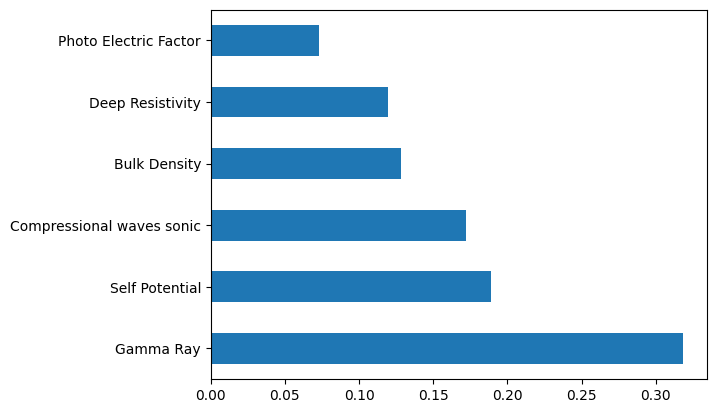

In [23]:
(
    pd.Series(clf.feature_importances_, index=train_X.columns)
    .nlargest(6)
    .plot(kind="barh")
)

Now let's calculate the cost difference:


Costs are taken from:
1. https://www.google.com.eg/books/edition/Report_No_FHWA_RD/AkxPAAAAMAAJ?hl=en&gbpv=0
2. https://www.researchgate.net/publication/339413312_Well_Logging_Analyzing_in_Misan_Province_South_of_Iraq_with_Estimation_of_Logging_Expenses?enrichId=rgreq-54386c63610c0a20cc94e70ef96413b7-XXX&enrichSource=Y292ZXJQYWdlOzMzOTQxMzMxMjtBUzo4NjEwNTQ5NDcwNDUzNzhAMTU4MjMwMjkwNTE4Nw%3D%3D&el=1_x_2&_esc=publicationCoverPdf

In [24]:
Original_Set = [
    "Shallow Resistivity",
    "Medium Deep Resistivity",
    "Deep Resistivity",
    "Bulk Density",
    "Gamma Ray",
    "Neutron Porosity",
    "Photo Electric Factor",
    "Compressional waves sonic",
    "Self Potential",
    "Density Correction",
]
Reduced_Set = [
    "Gamma Ray",
    "Deep Resistivity",
    "Bulk Density",
    "Self Potential",
    "Photo Electric Factor",
]


In [25]:
def compute_cost_per_meter(features_set, cost_dict):
    cost = 0
    for feature in features_set:
        if feature in cost_dict:
            cost += cost_dict[feature]
    return cost


First Company


In [26]:
Price_NAT_PET_SERV = {
    "Gamma Ray": 12,
    "Compressional waves sonic": 20,
    "Caliper": 15,
    "Bulk Density": 30,
    "Neutron Porosity": 40,
    "Resistivity": 50,
}

print("Original Set Cost: ", compute_cost_per_meter(
    Original_Set, Price_NAT_PET_SERV))
print("Reduced Set Cost: ", compute_cost_per_meter(
    Reduced_Set, Price_NAT_PET_SERV))


Original Set Cost:  102
Reduced Set Cost:  42


Second Company


In [27]:
Price_AWLCO = {
    "Gamma Ray": 4,
    "Compressional waves sonic": 1,
    "Caliper": 3,
    "Bulk Density": 4.5,
    "Neutron Porosity": 5.5,
    "Resistivity": 5,
}

print("Original Set Cost: ", compute_cost_per_meter(Original_Set, Price_AWLCO))
print("Reduced Set Cost: ", compute_cost_per_meter(Reduced_Set, Price_AWLCO))

Original Set Cost:  15.0
Reduced Set Cost:  8.5


Third Company


In [28]:
Price_OIL_SERV = {
    "Gamma Ray": 10,
    "Compressional waves sonic": 15,
    "Caliper": 12,
    "Bulk Density": 20,
    "Neutron Porosity": 30,
    "Resistivity": 40,
}

print("Original Set Cost: ", compute_cost_per_meter(Original_Set, Price_OIL_SERV))
print("Reduced Set Cost: ", compute_cost_per_meter(Reduced_Set, Price_OIL_SERV))


Original Set Cost:  75
Reduced Set Cost:  30
